In [1]:
from src.utils.utils import get_algo_by_name, get_env_by_name
from src.utils.save_results import get_task_name, get_metrics_information, get_results_file_name
import numpy as np
import time
import os
from datetime import date
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
today = date.today()
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()

def do_single_experiment(rd, settings):
    env = get_env_by_name(settings)
    env.set()
    agent = get_algo_by_name(settings)
    agent.set_environment(env)
    metrics = agent.iterate_learning()
    return metrics

In [2]:
nb_rds = 20
max_rounds = 1000
# nb_leaves_per_class = 10
nb_levels = 2

def do_paradox_experiment(nb_childs):

    exp3_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    exp3_rewards = np.zeros((nb_rds, int(max_rounds/100)))
    new_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    new_rewards = np.zeros((nb_rds, int(max_rounds/100)))
    nexp3_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    nexp3_rewards = np.zeros((nb_rds, int(max_rounds/100)))

    for rd in range(nb_rds):
        settings = {
            'rd': rd,
            'max_rounds': max_rounds,
            'nb_leaves_per_class': nb_childs,
            'nb_levels': nb_levels,
            'env': 'paradox',
            'algo': 'exp3',
        }
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        exp3_regrets[rd] = metrics['regret']
        exp3_rewards[rd] = metrics['reward']

        settings['algo'] = 'new'
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        new_regrets[rd] = metrics['regret']
        new_rewards[rd] = metrics['reward']
        
        settings['algo'] = 'nexp3'
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        nexp3_regrets[rd] = metrics['regret']
        nexp3_rewards[rd] = metrics['reward']

    # EXP3
    exp3_rgrt_std = np.std(exp3_regrets, axis=0)
    exp3_rwd_std = np.std(exp3_rewards, axis=0)
    exp3_regret = np.mean(exp3_regrets, axis=0)
    exp3_reward = np.mean(exp3_rewards, axis=0)
    
    exp3_result = (exp3_regret, exp3_rgrt_std, exp3_reward, exp3_rwd_std)

    # NEW
    new_rgrt_std = np.std(new_regrets, axis=0)
    new_rwd_std = np.std(new_rewards, axis=0)
    new_regret = np.mean(new_regrets, axis=0) 
    new_reward = np.mean(new_rewards, axis=0)
    
    new_result = (new_regret, new_rgrt_std, new_reward, new_rwd_std)

    # NEXP3
    nexp3_rgrt_std = np.std(nexp3_regrets, axis=0)
    nexp3_rwd_std = np.std(nexp3_rewards, axis=0)
    nexp3_regret = np.mean(nexp3_regrets, axis=0) 
    nexp3_reward = np.mean(nexp3_rewards, axis=0)
    
    nexp3_result = (nexp3_regret, nexp3_rgrt_std, nexp3_reward, nexp3_rwd_std)
    
    return exp3_result, new_result, nexp3_result, list(np.array(exp3_regrets)[:,-1]), list(np.array(new_regrets)[:,-1]), list(np.array(nexp3_regrets)[:,-1])

In [6]:
nb_childs = [2, 5, 10, 50]
res_new = []
res_nexp3 = []
res_exp3 = []
res=[]
labels=[]
exp3_results = []
nexp3_results = []
new_results = []

for nb_child in nb_childs:
    a,b,c,d,e,f = do_paradox_experiment(nb_child)
    res_exp3.append(list(d))
    res_new.append(e)
    res_nexp3.append(f)
    res.append(d)
    res.append(e)
    res.append(f)
    labels.append('EXP3 - N {}'.format(nb_child))
    labels.append('NEXP3 - N {}'.format(nb_child))
    labels.append('NEW - N {}'.format(nb_child))
    exp3_results.append(a)
    nexp3_results.append(b)
    new_results.append(c)

100%|██████████| 1000/1000 [00:00<00:00, 14597.31it/s]


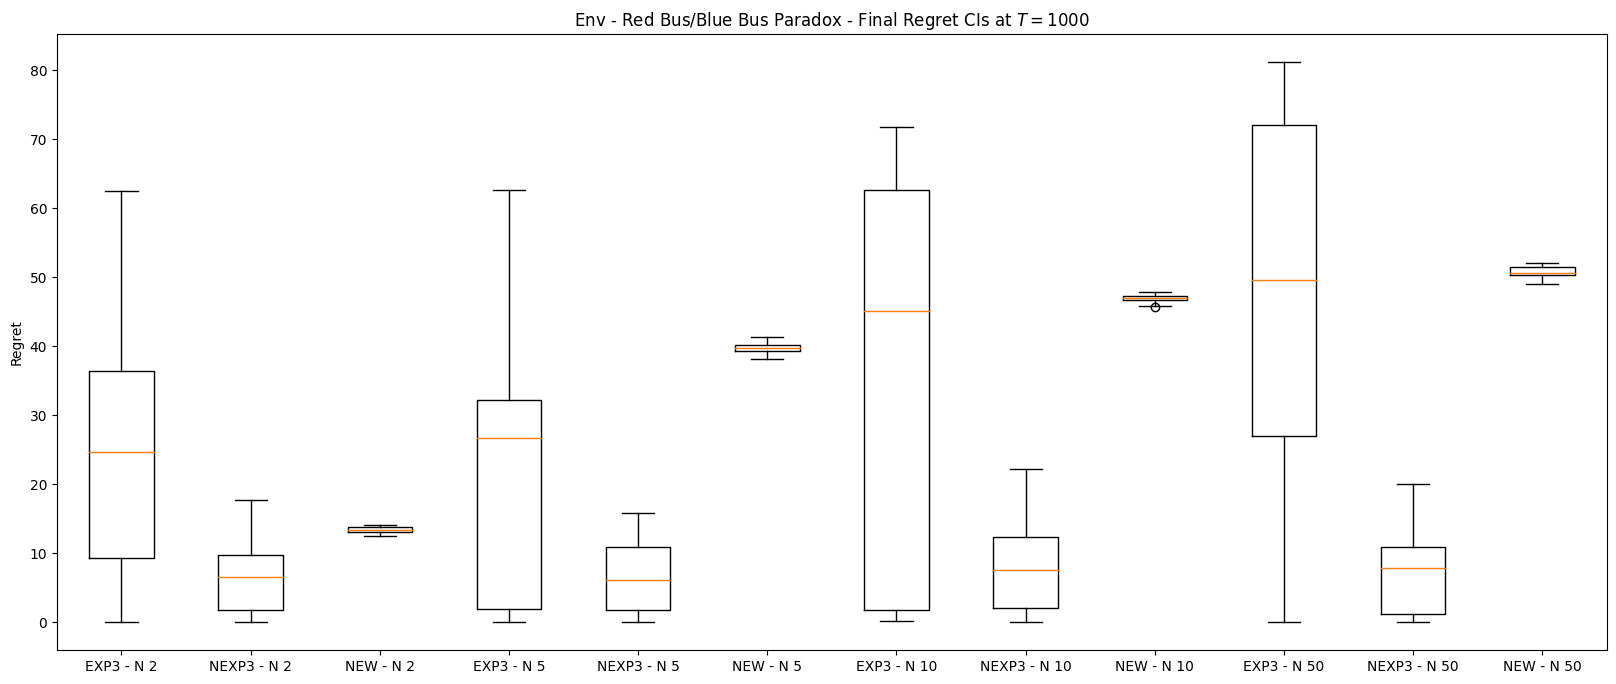

In [7]:
plt.figure(figsize=(20,8))
plt.boxplot(res, labels=labels)
plt.ylabel('Regret')
plt.title('Env - Red Bus/Blue Bus Paradox - Final Regret CIs at $T=1000$')

plt.savefig('figure_bbrb_regret_slice.pdf', bbox_inches = "tight")
plt.show()

def sample_action(self, round):
        self.lr = 1 / np.sqrt(round+1)
        leaves = self.environment.tree.get_all_leaves()
        a_t = self.rng.choice(range(self.K), 
                              p = self.proba)
        leaves_name = [leaf.name for leaf in self.leaves]

        node_path = []
        proba_path = []
        reward_path = []
        node = leaves[a_t]
        reward_path.append(self.environment.get_reward_by_node(node))
        node_path.append(a_t)
        proba_path.append(self.proba[a_t])

        past_vector_proba = self.proba
        past_indexes = range(self.K)
        past_nodes = self.leaves
        past_names = [leaf.name for leaf in past_nodes]

        while bool(node.parent):
            parent = node.parent

            current_nodes = list(set([node.parent for node in past_nodes]))
            current_names = [n.name for n in current_nodes]
            current_indexes = len(current_nodes)
            current_vector_proba = np.zeros(current_indexes)
            for i,node in enumerate(current_nodes):
                childrens_node = node.children
                childrens_name = [c.name for c in childrens_node]
                indexes = [i for i,past_name in enumerate(past_names) if past_name in childrens_name]
                current_vector_proba[i] = np.sum(past_vector_proba[indexes])

            index_parent = list(current_names).index(parent.name)
            proba_path.append(current_vector_proba[current_vector_proba[index_parent]])
            

            node_path.append(parent) 
            reward_parent = self.environment.get_reward_by_node(parent)
            reward_path.append(reward_parent)
            node = parent
            past_vector_proba = current_vector_proba
            past_indexes = current_indexes
            past_nodes = current_nodes
            past_names = current_names

        node_path = node_path[::-1] 
        reward_path = reward_path[::-1]
        proba_path = proba_path[::-1]
        
        return a_t, node_path, reward_path, proba_path

In [ ]:
settings = {
            'rd': 10,
            'max_rounds': 10,
            'nb_leaves_per_class': 10,
            'nb_levels': 2,
            'env': 'paradox',
            'algo': 'exp3',
        }
env = get_env_by_name(settings)
env.set()
#agent = get_algo_by_name(settings)
agent = NEXP3(settings)
agent.set_environment(env)
agent.iterate_learning()

100%|██████████| 10/10 [00:00<00:00, 1087.06it/s]


{'reward': [0.6354788401368608], 'regret': [0.06585764221240198], 'round': [0]}